# Locating quakes on Grimsvötn, Iceland
_Accompanying notebook for HMCLab_

_Copyright 2022, Lars Gebraad, Andrea Zunino, Andreas Fichtner, Sara Klaasen_

![title](locatingquakes/data/aerial-snowcat-truck-people-grimsvotn.jpg)
_A superjeep and a snowcat used by researchers atop Grímsvötn are seen in this drone-captured photo, with the volcanic caldera in the background. Credit: Hildur Jónsdóttir_

This notebook demos the HMCLab software in a real data application. It highlights different approaches to make Probabilistic interpretations of data accessible and possible. The important concepts for this notebook are Hamiltonian Monte Carlo, Parallel tempering and simply model of physics.

We study data obtained at the Grimsvötn volcano in Iceland. Here, seismic data was captured using a distributed acoustic sensing (DAS) fiber. We will try to place events recorded with that cable using a homogeneous subsurface model, and probabilistic interpretation of the data. We show how this is possible with HMCLab, and why it is essential to use HMC + mutliple markov chains to solve this inverse problem. Lastly, we'll have some fun with the results, to also show how the probabilistic interpretation has practical uses.

For more information on the fieldwork, we refer to Sara Klaasen [(sara.klaasen@erdw.ethz.ch)](mailto:sara.klaasen@erdw.ethz.ch), or to read the articles [here at EOS](https://eos.org/science-updates/sensing-icelands-most-active-volcano-with-a-buried-hair) or [here at ETH Ambassadors](https://ethambassadors.ethz.ch/2021/10/28/measuring-the-fiery-pulse-beneath-europes-largest-glacier/).

Let's first get our imports out of the way:

In [2]:
# These two imports belong to HMCLab
import hmclab
from locatingquakes.helpers import *  # With this one just providing nice tools for only this notebook

# And all the following should be installed with HMCLab
import numpy, glob, matplotlib.pyplot as plt, pandas
import tilemapbase, glob, math
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.colors import LogNorm


# Alter to make the plots size appropriate for your screen
figsize = (6, 6)
figsize_double = (12, 6)
figsize_32 = (18, 12)
figsize_triple = (18, 6)

## Intro

This notebook let's us invert for multiple earthquake source locations in a 3D space, given some known or unknown homogeneous medium velocity and unknown origin time. 

We will go through the following sections in this notebook:

1. Straight ray homogeneous medium traveltime **physics**, i.e. simply distance / time = velocity;
2. **Geometry and domain:** An array of receivers that observers the first arrival of the event, e.g. a picked arrival time on a seismogram. In this notebook, we will use a DAS array deployed on the Grimsvötn caldera;
3. Probabilistic interpretation of the **data**;
4. Modelling our **prior** expectations, creating a **posterior**;
5. **Sampling** using parallel Hamiltonian Monte Carlo;
6. **Analsysis and interpretation** of the samples.

## 1: The physics

The physics of first arrivals is modeled simply by calculating the distance between source and receivers, and calculating the travel time between those points for a given medium velocity. This is implemented in `hmclab.Distributions.SourceLocation3D`. It also includes the gradients for a given set of locations, i.e. in what direction one would have to perturb their sources to increase data fit. So, in this seciton, there is nothing to do!

## 2: The domain

In this section, we will load the domain and DAS receiver geometry. These are supplied in polar coordinates, so we will use ObsPy in the background to convert these to a local coordinate system in kilometers.

In [3]:
df = pandas.read_csv("locatingquakes/data/xyz_polar.csv", delimiter=",")
channel = df["channels"].values
lon_das_polar = df["longitude"].values
lat_das_polar = df["latitude"].values
z_das_polar = df["elevation"].values

# Define the middle of the array as our new local origin.
origin = (lon_das_polar.mean(), lat_das_polar.mean())

Now we convert the geometry given in polar coordinates to a local cartesian interpretation using the new origin, and work in meters rather than kilometers.

In [4]:
x_das, y_das = to_xyz(
    lon_das_polar, lat_das_polar, (lon_das_polar.mean(), lat_das_polar.mean())
)

# to meters
x_das *= 1e3
y_das *= 1e3
z_das = z_das_polar

print(f"Number of channels: {x_das.shape[0]}")

Number of channels: 1494


Let's compare these two representations of our geometry, just to get a feeling of the domain we work in.

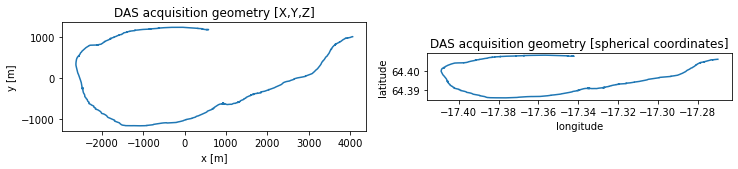

In [5]:
plt.figure(figsize=figsize_double)
plt.subplot(121)
plt.title("DAS acquisition geometry [X,Y,Z]")
plt.plot(x_das, y_das)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.gca().set_aspect(1)

plt.subplot(122)
plt.title("DAS acquisition geometry [spherical coordinates]")
plt.plot(lon_das_polar, lat_das_polar)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.gca().set_aspect(1)

This, of course, looks better on an actual map. It is a bit tedious to plot the XYZ system we use on a map, requiring 2 transformations (XYZ->latlon->map unit square). 

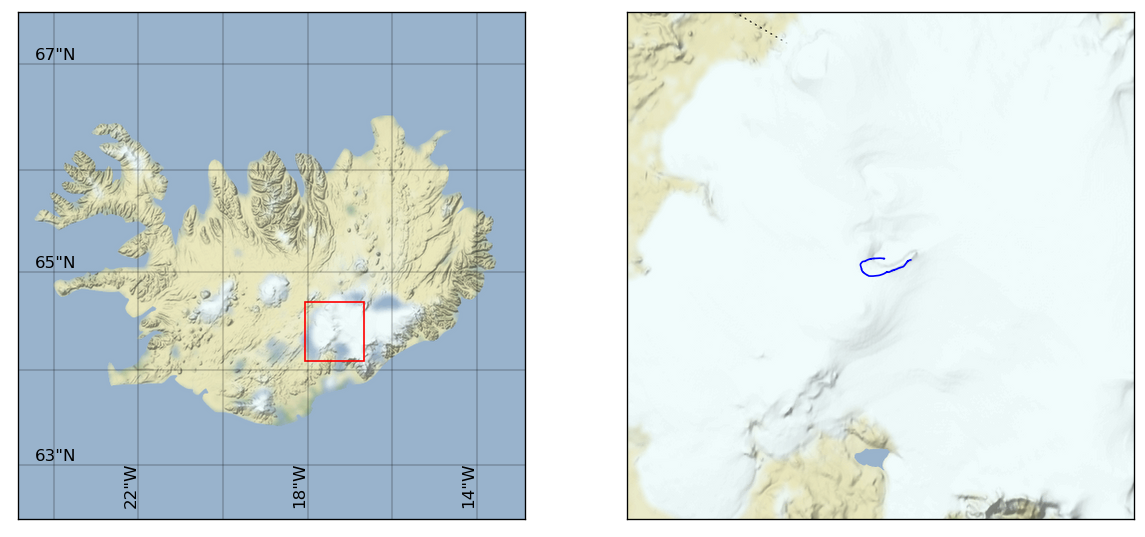

In [23]:
# Set the background image source
tilemapbase.init(create=True)
map_background = tilemapbase.tiles.Stamen_Terrain_Background

# Set the map extent of the maps
degrees_range1 = 3
extent1 = tilemapbase_create_extent(
    (lon_das_polar.mean() - 1.5, lat_das_polar.mean() + 0.5), degrees_range1
)
degrees_range2 = 0.35
extent2 = tilemapbase_create_extent(
    (lon_das_polar.mean(), lat_das_polar.mean()), degrees_range2
)

# Create figure and axes
fig = plt.figure(figsize=figsize_double, dpi=120)
ax1 = plt.subplot(121)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax2 = plt.subplot(122)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)

# Create the backgrounds in the axes
plotter1 = tilemapbase.Plotter(extent1, map_background, width=400)
plotter1.plot(ax1, map_background)
plotter2 = tilemapbase.Plotter(extent2, map_background, width=400)
plotter2.plot(ax2, map_background)

# Plot the inset
rectangle = patches.Rectangle(
    (extent2.xmin, extent2.ymin),
    extent2.width,
    extent2.height,
    linewidth=1,
    edgecolor="r",
    facecolor="none",
    label="detail",
)
ax1.add_patch(rectangle)

# Project the DAS geometry to map coordinates
xproj_das, yproj_das = tilemapbase_project_array(
    lon_das_polar, lat_das_polar, tilemapbase.project
)

# Plot the cable
ax2.plot(xproj_das, yproj_das, color="b", linewidth=1, label="DAS acquisition geometry")

# Plot a grid (messy!)

## AX 2
## LONS

lo, ro = lon_das_polar.mean() - 8, lon_das_polar.mean() + 10

for cor in numpy.arange(63, 68, 1.0):
    xproj_grid, yproj_grid = tilemapbase_project_array(
        [ro, lo],
        [cor, cor],
        tilemapbase.project,
    )
    ax1.plot(xproj_grid, yproj_grid, color="k", linewidth=0.2, alpha=1)

    if (cor - 1) % 2 == 0:
        ax1.text(xproj_grid[1] + 0.0025, yproj_grid[0] - 3e-4, f'{int(cor)}"N')


## LATS
la, ra = lat_das_polar.mean() - 2.5, lat_das_polar.mean() + 3.5
for cor in numpy.arange(-24, -10, 2.0):
    xproj_grid, yproj_grid = tilemapbase_project_array(
        [cor, cor],
        [ra, la],
        tilemapbase.project,
    )
    ax1.plot(xproj_grid, yproj_grid, color="k", linewidth=0.2, alpha=1)

    if (cor - 2) % 4 == 0:
        ax1.text(
            xproj_grid[0] - 1e-3,
            yproj_grid[1] - 0.004,
            f'{int(abs(cor))}"W',
            ha="left",
            rotation=90,
        )


# ## AX 2

# ## LONS
# lo, ro = lon_das_polar.mean() - 0.75, lon_das_polar.mean() + 0.75

# for cor in numpy.arange(64.2, 64.8, 0.2):
#     xproj_grid, yproj_grid = tilemapbase_project_array(
#         [ro, lo],
#         [cor, cor],
#         tilemapbase.project,
#     )
#     ax2.plot(xproj_grid, yproj_grid, color="k", linewidth=0.2, alpha=1)
#     if True:  # (cor - 1) % 2 == 0:
#         ax2.text(
#             xproj_grid[1] + 0.00025, yproj_grid[0] - 3e-5, f'{numpy.round(cor,1)}"N'
#         )

# # lat = [64.0, 64.0, 64.2, 64.2, 64.4, 64.4, 64.6, 64.6, 64.8, 64.8, 65, 65]
# # xproj_grid, yproj_grid = tilemapbase_project_array(
# #     [lo, ro, ro, lo] * 3,
# #     lat,
# #     tilemapbase.project,
# # )
# # ax2.plot(xproj_grid, yproj_grid, color="k", linewidth=0.2, alpha=1)

# # for i in [3, 7]:
# #     ax2.text(xproj_grid[i] + 1.6e-4, yproj_grid[i] - 3e-5, f'{lat[i]}"N')

# ## LATS
# la, ra = lat_das_polar.mean() - 0.3, lat_das_polar.mean() + 0.3
# for cor in numpy.arange(-18, -16, 0.4):
#     xproj_grid, yproj_grid = tilemapbase_project_array(
#         [cor, cor],
#         [ra, la],
#         tilemapbase.project,
#     )
#     ax2.plot(xproj_grid, yproj_grid, color="k", linewidth=0.2, alpha=1)

#     if numpy.round(cor * 10) % 8 == 0:
#         ax2.text(
#             xproj_grid[0] - 1.3e-4,
#             yproj_grid[1] - 0.000075,
#             f'{(numpy.round(abs(cor),1))}"W',
#             ha="left",
#             rotation=90,
#         )


# # Plot a city
# reykjavik = [-21.9426], [64.1466]
# xproj_reykjavik, yproj_reykjavik = tilemapbase_project_array(
#     reykjavik[0],
#     reykjavik[1],
#     tilemapbase.project,
# )
# ax1.scatter(xproj_reykjavik, yproj_reykjavik, marker="h", c="k")  # , label="Reykjavik")
# ax1.annotate(
#     "Reykjavik",
#     xy=tuple(1.002 * numpy.array([xproj_reykjavik, yproj_reykjavik]).flatten()),
#     fontweight=600,
# )


# grimsvotn = [-17.163333], [64.42]
# xproj_reykjavik, yproj_reykjavik = tilemapbase_project_array(
#     grimsvotn[0],
#     grimsvotn[1],
#     tilemapbase.project,
# )
# ax1.scatter(xproj_reykjavik, yproj_reykjavik, marker="h", c="k")  # , label="Reykjavik")
# ax1.annotate(
#     "Grimsvötn",
#     xy=tuple(1.004 * numpy.array([xproj_reykjavik, yproj_reykjavik]).flatten()),
#     fontweight=600,
# )


# ax1.set_title("Area of interst in Iceland")
# ax2.set_title("Detail map")


# # Add legends
# _ = ax1.legend()
# _ = ax2.legend()

## 3: Understanding the data and its uncertainty

We have pre-processed all the data in the `data/` folder. The notebook in that folder contains the pre-processing steps.

In [7]:
events_to_use = [1, 3, 4, 5, 6, 8, 10]

data_array = numpy.load("locatingquakes/data/data_array.npy")[:, events_to_use]
uncertainty_array = numpy.load("locatingquakes/data/uncertainty_array.npy")[
    :, events_to_use
]
snr_array = numpy.load("locatingquakes/data/snr_array.npy")[:, events_to_use]
event_descriptions = [
    file.split(".")[0] for file in list(numpy.load("locatingquakes/data/csv_files.npy"))
]
event_descriptions = list(numpy.array(event_descriptions)[events_to_use])

n_events = data_array.shape[1]

**Data uncertainty**

In our Bayesian interpration, we use the L2 misfit function on first arrivals. The L2 metric allows for a data covariance matrix in the following way:

$$
    \mathbf{r} = \mathbf{d}_{obs} - \mathbf{d}_{syn} \\
    \chi_{L2} = \frac{1}{2} \mathbf{r}^ T \, C_D^{-1}\, \mathbf{r} 
$$

Where $\mathbf{d}_{obs}$ and $\mathbf{d}_{syn}$ respectively describe the osberved and synthetic data, $\mathbf{r}$ the data residual, and $C_D$ the data covariance matrix.

The data uncertainty defines how much trust we put in the compound of our picks, theory, and other components that might introduce errors. Using a large number will allow data that deviates strongly from the observations, a low value only allows models to rigorously fit the data. Theoretically, this number is a defined quantity. However, we usually lack the tools, or even comprehension, to do a full analysis of all sources of uncertainty. Therefore, we simplify the value in this notebook by only taking the Signal-to-Noise (SNR) ratio (which influences picking uncertainty) and our modelling uncertainty into account.

Note that by only calculating the data variance, we make $C_D$ a diagonal matrix. This means that two data points are always assumed to be completely uncorrelated. This can be extended to include spatio-temporal correlations, but that is outside the scope of this notebook.

In our case, we are fairly certain that the homogeneous model is not accurate enough to explain all first arrivals. Hence we might want to allow slight variations to our observed data. But how much would our limited model (straight rays, homogeneous velocity) influence arrival times exactly? This is very hard to estimate, but judging by the data, we don't want to be too much off, i.e. we don't want to give a very high value. This value effectively sets the lower bound for data fitting. If only the data covariance from the SNR is used, very small data covariance values are possible. We don't think our physics can explain such small variations, so we opted for $0.1s$.

Luckily, we are supplied with SNR ratios for every channel/event combination. Now, we can easily calculate the total uncertainty from these values.

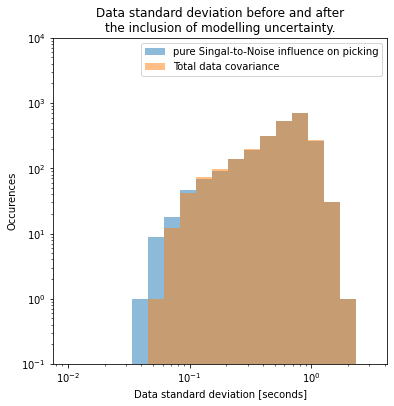

In [8]:
# Try out different values!
modelling_variance = 0.05**2

data_covariance = 1.0 / snr_array + modelling_variance

logbins = numpy.logspace(-2, 0.5, 20)

plt.figure(figsize=figsize)
plt.title(
    "Data standard deviation before and after\nthe inclusion of modelling uncertainty."
)

_ = plt.hist(
    ((1.0 / snr_array) ** 0.5).flatten(),
    bins=logbins,
    alpha=0.5,
    label="pure Singal-to-Noise influence on picking",
)

_ = plt.hist(
    (data_covariance**0.5).flatten(),
    bins=logbins,
    alpha=0.5,
    label="Total data covariance",
)

plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.ylim([1e-1, 1e4])
plt.legend()
_ = plt.ylabel("Occurences")
_ = plt.xlabel("Data standard deviation [seconds]")

Effectively, adding modelling uncertainty cut off the left tail of this distribution: thereby avoiding overfitting.

For completeness, the $\chi_{L2}$ is the function that Hamiltonian Monte Carlo will explore, possibly with terms added for the prior. Exploring this function will draw samples proportional to:

$$
    p \propto exp \left( - \chi_{L2} \right) 
$$

At this point, we can have a look at the data itself, and the accompanying uncertainties we just computed. Because not every event is observed on every channel, some data is missing. The algorithm will ignore the empty channels.

But, ignoring the empty channels means that the events that are observed on less will also have less of a contribution to the total likelihood. Thereby, we expect that these events see higher uncertainties or worse data fits.

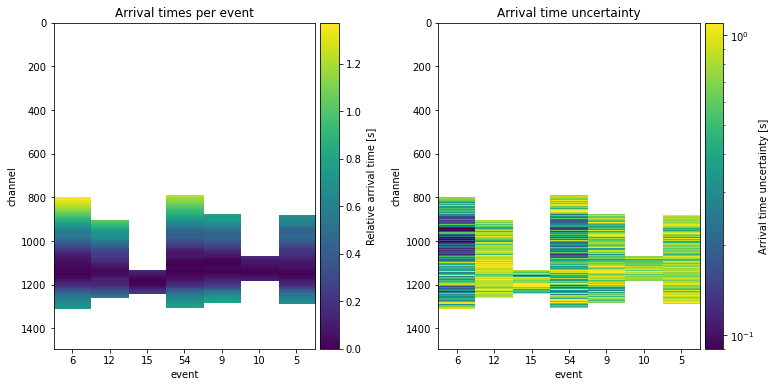

In [10]:
fig = plt.figure(figsize=figsize_double)

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=None
)


ax = plt.subplot(121)
plt.title("Arrival times per event")
im1 = ax.imshow(data_array, interpolation="none")
plt.xlabel("event")
plt.ylabel("channel")
plt.xticks(numpy.arange(n_events), event_descriptions)


ax1_divider = make_axes_locatable(ax)
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cb1 = fig.colorbar(im1, cax=cax1)
cb1.ax.set_ylabel("Relative arrival time [s]")


ax.set_aspect("auto")


ax = plt.subplot(122)
plt.title("Arrival time uncertainty")
im1 = ax.imshow(
    data_covariance**0.5, interpolation="none", norm=LogNorm(vmin=0.09, vmax=1.1)
)
plt.xlabel("event")
plt.ylabel("channel")
plt.xticks(numpy.arange(n_events), event_descriptions)
ax1_divider = make_axes_locatable(ax)
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cb1 = fig.colorbar(im1, cax=cax1)
cb1.ax.set_ylabel("Arrival time uncertainty [s]")
ax.set_aspect("auto")

## 4: Creating the Bayesian interpretation

The next step is integrating all our data and knowledge into probability density functions.

For our **prior** knowledge, we make a few key assumptions, but try to hold back on forcing the inversion in any direction. We will asumme that the event occurs within a square around the zero, with edge length 16km, but truncated at 2000 meter elevation (fairly decent assumption we hope). We will also assume that all events occur _before_ the very first arrival on the das cable. Although this makes physical sense to us, we need to tell this to the probability distribution. Below there is a uniform distribution with these parameters created for a single event, and repeated as many times as needed.

Lastly **the prior on the velocity** is a harder thing to define. especially since every event might require a very different effective medium velocity. It will likely actually matter *per channel* what the effective medium velocity is. However, this homogeneous model is a decent simplification for now. We chose to use a uniform prior between 10m/s and 10'000m/s. This can be changed to investigate results for a more specific medium velocity.

For the **data**, this includes the data we just saw, combined with our defined uncertainty and a measure of data fit. We will use an L2 misfit between the synthetic (or predicted) data and the observations. This misfit allows us to directly integrate our uncertainty in a straightforward way. This misfit is standard in `hmc_tomography.Distributions.SourceLocation3D`.

**Tempering**

Note that tempering is used. This means we take our posterior, and allow much worse solutions for a while. This is a typical technique for Monte Carlo, where our first Markov chain samples much worse misfits, to find as much minima as it can. We will run a few Markov chains at the true solution, and a few tempered. All the chains attempt to exchange states with eachother at pre-specified intervals.

In [11]:
# Create prior ----------------------------------------------------------------
# X,Y: within -8km <-> 8km square (edge length 16km)
# Z: between -8km <-> 2km
# T: between -10, 1 (anything higher than 0 is later than the first arrival: actually unpyhysical)
source_pos_time_prior = hmclab.Distributions.Uniform(
    [-8000, -8000, -8000, -10], [8000, 8000, 2000, 1]
)

# V: Uniform between 10/s <-> 10'000 m/s
# vel_prior = hmclab.Distributions.Uniform([10], [7])

vel_prior = hmclab.Distributions.Uniform([numpy.log10(343)], [numpy.log10(7000)])

vel_prior = hmclab.Distributions.TransformToLogSpace(vel_prior)

# Combine all priors
# One could give a different location prior to each event,
# but here the priors are kept constant.
prior = hmclab.Distributions.CompositeDistribution(
    [source_pos_time_prior] * n_events + [vel_prior]
)

# Create the same posterior 10 times  ------------------------------------------
algorithm_replicas = 10

posteriors = []

# This schedule gives half the chains T=1, and the other half are increasing
# temperature. All chains exchange information.
temperatures = numpy.concatenate(
    (
        numpy.array([1] * int(algorithm_replicas / 2)),
        numpy.logspace(0, 4, algorithm_replicas - int(algorithm_replicas / 2)),
    )
)
sqr3 = 3**0.5
temperatures = [
    1.0,
    1.0,
    sqr3,
    3.0,
    3.0 * sqr3,
    10.0,
    10.0 * sqr3,
    30.0,
    30.0 * sqr3,
    100.0,
]

for i in range(algorithm_replicas):

    # Tempering is simply scaling the covariance for the L2 function
    covariance = (temperatures[i]) * data_covariance

    likelihood = hmclab.Distributions.SourceLocation3D(
        x_das[None, :],
        y_das[None, :],
        z_das[None, :],
        data_array.T,
        covariance.T**0.5,  # The module takes in only data standard deviation
        True,  # Invert for velocity
    )

    # Combine the prior with the (possible tempered) posterior
    posterior = hmclab.Distributions.BayesRule([likelihood, prior])
    posteriors.append(posterior)

print(f"Temperature schedule: {[(temp) for temp in temperatures]}")

Temperature schedule: [1.0, 1.0, 1.7320508075688772, 3.0, 5.196152422706632, 10.0, 17.32050807568877, 30.0, 51.96152422706631, 100.0]


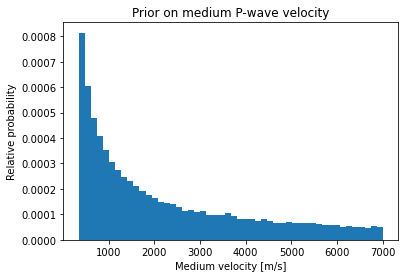

In [12]:
plt.title("Prior on medium P-wave velocity")
_ = plt.hist((vel_prior.generate(50000).flatten()), bins=50, density=True)
plt.xlabel("Medium velocity [m/s]")
plt.ylabel("Relative probability")
plt.show()

## 5: Sampling

Now we can _almost_ start sampling. We first need to say at what model parameters (medium velocity, locations) our samplers should start.

There are multiple schools of thought regarding starting models. One can advocate to remove all bias, and draw starting models from the prior distribution. One might also be able to come up with a guess based on the physics at hand, greatly accelerating the initial burn-in phase at the risk of biasing the algorithms. Below, we have implemented both. 

Simply change `use_guesses` to False to use a completely random prior model. Leaving `use_guesses` as True will use the horizontal location of the channel that detects the event earliest. It will subsequently draw a random depth, and use origin time 0. **By also randomizing this initial depth per algorithm copy**, we are able to test the influence of the starting model.

In [15]:
use_guesses = True  # Change this if you want!

rng = numpy.random.default_rng(12345)

# Create starting models ------------------------------------------------------
# Find on which channel the minimum arrival time is
first_arrival_channel = numpy.nanargmin(data_array, axis=0)

# Use horizontal location of channel as initial location for each event
guess_x = x_das[numpy.nanargmin(data_array, axis=0)]
guess_y = y_das[numpy.nanargmin(data_array, axis=0)]
guess_t = numpy.zeros_like(guess_y)
guess_velocity = 1200


starting_models = []
if use_guesses:
    for i in range(algorithm_replicas):
        # Generate a random depth, different for each copy of the algorithm we are running/\
        random_z = rng.uniform(-3999, z_das_polar.max(), guess_y.shape)

        # Wrap everything up in the order: x1,y1,z1,t1,x2,y2,z2, ..., v0
        # i.e. 'weaving multiple arrays'
        starting_model = sum(
            map(list, zip(guess_x, guess_y, random_z, guess_t)), []
        ) + [guess_velocity]

        # And put them in a list
        starting_models.append(numpy.array(starting_model)[:, None])
else:
    # Generate random starting models for every copy of the algorithm.
    starting_models = [prior.generate(rng=rng) for i in range(algorithm_replicas)]

Let's look at where the locations start out:

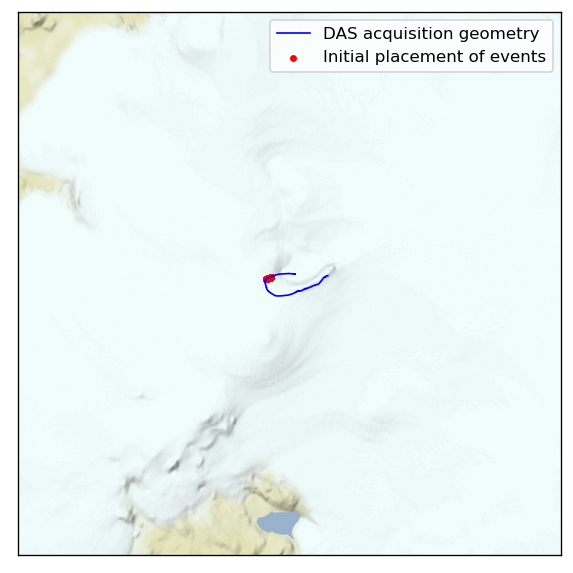

In [16]:
# Set the background image source
tilemapbase.init(create=True)
map_background = tilemapbase.tiles.Stamen_Terrain_Background

# Set the map extent of the large map
degrees_range1 = 0.3
extent1 = tilemapbase_create_extent(
    (lon_das_polar.mean(), lat_das_polar.mean()), degrees_range1
)

# Create figure and axes
fig = plt.figure(figsize=figsize, dpi=120)
ax1 = plt.gca()
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)

# Create the plotter for axes
plotter1 = tilemapbase.Plotter(extent1, map_background, width=400)
plotter1.plot(ax1, map_background)


# Plot the cable
ax1.plot(xproj_das, yproj_das, color="b", linewidth=1, label="DAS acquisition geometry")

for i in range(algorithm_replicas):

    start_x = starting_models[i][:-1:4, :]
    start_y = starting_models[i][1::4, :]

    guess_lon, guess_lat = to_lonlat(start_x / 1e3, start_y / 1e3, origin)
    guess_projx, guess_projy = tilemapbase_project_array(
        guess_lon, guess_lat, tilemapbase.project
    )

    label = None
    if i == 0:
        label = "Initial placement of events"
    ax1.scatter(guess_projx, guess_projy, s=10, c="r", label=label)


# Add legends
_ = ax1.legend()

All good, looks like we have one clusters.

Now that we are about to create the sampler, we should think about preconditioning it using the mass matrix. This mass matrix accelerates the algorithm by scaling the posterior dimensions, but it does not alter the results of the Markov chain. It simply enhances the efficiency. 

Ideally, one would have a certain expectation on the variation of each parameter, and include that in the mass matrix. In this case, we expect variation to vary on the order of 1e3, velocity on the order of 1e2 and origin time only on the order of 1e0. The mass matrix should be approximately equal to the inverse posterior covariance matrix for optimal results, hence the reciprocal of our expected variance has become our mass matrix diagonal.

We have left the code for a non-perconditioned version of HMC, using a Unit mass matrix. Using that will likely yield worse results.

In [17]:
# Create the mass matrix ----------------------------------------------
mass = hmclab.MassMatrices.Diagonal(
    1.0 / (numpy.array([1000, 1000, 1000, 1] * n_events + [100]))[:, None]
)

# Uncomment to try a Unit mass matrix.
# mass = hmclab.MassMatrices.Unit(diagonal.size)

Now, we are all set to sample. We create the parallel infrastructure using the controller `ParallelSampleSMP` (which stands for shared memory pool, i.e. samplers that run on a single machine). We give this controller all samplers (i.e. 10 copies of HMC), all filenames to which to save our samples, and all posteriors.

Additionally, we tell the controller to exchange samples after 5 HMC proposals. This ensures that the high temperature chains supply distant models to our $T=1$ chains. Finally, we let the HMC algorithms autotune their stepsize. By lowering the target acceptance rate and slightly increasing the amount of steps, one obtains slightly more distant samples, useful in cheap but strongly non-linear models, such as this. The exact numbers one should use are not known, so `amount_of_steps` is a parameter that should still be chosen with some trial and error. When in doubt, values around `10` seem to work well.

In [18]:
# Sample ----------------------------------------------------------------------
parallel_controller = hmclab.Samplers.ParallelSampleSMP()

samplers = [hmclab.Samplers.HMC() for i in range(algorithm_replicas)]
filenames = [
    f"locatingquakes/samples/samples_grimsvotn_{i}.h5"
    for i in range(algorithm_replicas)
]

# parallel_controller.sample(
#     samplers,
#     filenames,
#     posteriors,
#     overwrite_existing_files=True,
#     exchange=True,
#     exchange_interval=10,
#     proposals=int(1e7),
#     kwargs={
#         "autotuning": True,
#         "mass_matrix": mass,
#         "online_thinning": 5,
#         "target_acceptance_rate": 0.4,
#         "amount_of_steps": 15,
#     },
#     initial_model=starting_models,
# ).print_results()

In [19]:
parallel_controller.print_results()

AttributeError: 'ParallelSampleSMP' object has no attribute 'sampler_widget_data'

## 6: Analysis and interpretation

A good first start is almost always to look at the misfit during the chain. Altough we altered our posteriors by tempering, it is fairly easy to obtain the original misfits (i.e. probabilities) if that chain would have been run at $T=1$.

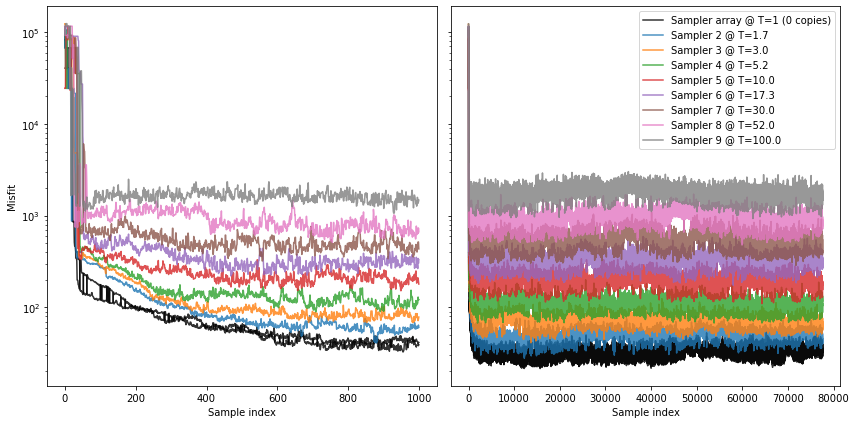

In [20]:
# Plot misfit over time ---------------------------------------------------

plt.figure(figsize=figsize_double)

ax1 = plt.subplot(121)
ax2 = plt.subplot(122, sharey=ax1)

for i in range(algorithm_replicas):

    # Load ALL sample misfits
    with hmclab.Samples(filenames[i]) as samples:
        samples_misfits = samples.misfits

    # Set labels and colours
    label = f"Sampler {i} @ T={temperatures[i]:.1f}"
    c = None
    if temperatures[i] == 1:
        c = "k"
        if i == 0:
            label = f"Sampler array @ T=1 ({numpy.sum(temperatures==1)} copies)"
        else:
            label = None

    # Correct the misfit for temperature
    misfits_corrected = samples_misfits * temperatures[i]

    ax1.semilogy(misfits_corrected[:1000], alpha=0.8, label=label, c=c)
    ax2.plot(misfits_corrected, alpha=0.8, label=label, c=c)
    ax1.set_xlabel("Sample index")
    ax2.set_xlabel("Sample index")
    ax1.set_ylabel("Misfit")
    plt.tick_params("y", labelleft=False)
    plt.tight_layout()

plt.legend()
plt.show()

Seems good. Initially (on the left), most Markov chains are strongly in the burn-in phase. We can see that after approximately 100 samples seemingly stable levels are reached.

If we visualize the velocities that are sampled in all seperate chains (below), we see how the chains ran at higher temperatures are more lenient in admitting larger variations. Where the original inverse problems sample only very small misfits, the 'hot' chains are allowed to make guesses that are of much higher misfit. Thereby, these chains might move into different 'basins of attraction', or modes, in the misfit/pdf landscape. As these chains exchange states, the 'hot' chains help the original inverse problems (the 'cold' chains) to converge much faster (i.e. explore all relevant local minima).

In [21]:
numpy.array(temperatures)==1.0

array([ True,  True, False, False, False, False, False, False, False,
       False])

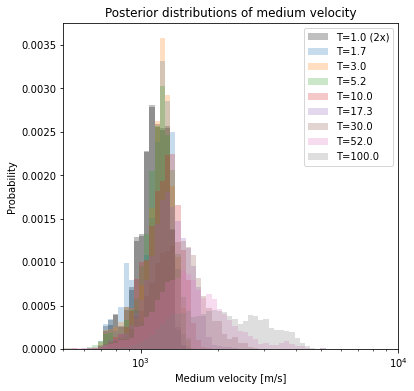

In [22]:
plt.figure(figsize=figsize)
logbins = numpy.logspace(1, 4, 150)


for i in range(algorithm_replicas):
    with hmclab.Samples(filenames[i]) as samples:
        samples_n = samples.numpy
        color = None
        if temperatures[i] == 1:
            color = "k"

        label = f"T={temperatures[i]:.1f}"
        if temperatures[i] == 1 and (not i == 0):
            label = None
        elif temperatures[i] == 1:
            label = f"T={temperatures[i]:.1f} ({numpy.sum(numpy.array(temperatures)==1.0)}x)"

        plt.hist(
            samples_n[-2, :],
            bins=logbins,
            range=(1e2, 1e4),
            alpha=0.25,
            color=color,
            density=True,
            label=label,
        )

plt.legend()
plt.xlim([500, 10000])
plt.xlabel("Medium velocity [m/s]")
plt.ylabel("Probability")
plt.title("Posterior distributions of medium velocity")
plt.gca().set_xscale("log")

We sampled the actual posterior using multiple Markov chains, so we can now combine their results together in an ensemble. We will print the best model in each chain.

In [297]:
# Load samples ----------------------------------------------------------------
for i in range(algorithm_replicas):
    with hmclab.Samples(filenames[i], burn_in=1000) as samples:
        samples_n = samples.numpy

    best_model_chain = samples_n[:-1, numpy.argmin(samples_n[-1, :])][:, None]

    print(
        f"Chain {i}, temperature {temperatures[i]:.2f},\t"
        f"Minimum misfit: {posteriors[0].misfit(best_model_chain):.2f}"
    )

print()
final_samples = []
for i in range(algorithm_replicas):

    if temperatures[i] != 1:
        break

    print(f"Adding chain {i} with temperature 1 to final results")

    with hmclab.Samples(filenames[i], burn_in=1000) as samples:
        final_samples.append(samples.numpy)

final_samples = numpy.hstack(final_samples)


best_model_overall = final_samples[:-1, numpy.argmin(final_samples[-1, :])][:, None]
synthetics_best_model_overall = likelihood.forward_vector(best_model_overall)

Chain 0, temperature 1.00,	Minimum misfit: 21.56
Chain 1, temperature 1.00,	Minimum misfit: 21.53
Chain 2, temperature 1.73,	Minimum misfit: 22.20
Chain 3, temperature 3.00,	Minimum misfit: 25.59
Chain 4, temperature 5.20,	Minimum misfit: 36.17
Chain 5, temperature 10.00,	Minimum misfit: 39.35
Chain 6, temperature 17.32,	Minimum misfit: 46.44
Chain 7, temperature 30.00,	Minimum misfit: 56.74
Chain 8, temperature 51.96,	Minimum misfit: 74.61
Chain 9, temperature 100.00,	Minimum misfit: 154.66

Adding chain 0 with temperature 1 to final results
Adding chain 1 with temperature 1 to final results


It's a little bit cleaner to plot the velocity of the combined ensemble. If this distrubtion is strongly multimodal, this indicates that the events can not be well explained by a homogeneous medium. Luckily, with the Bayesian approach, we can investigate this.

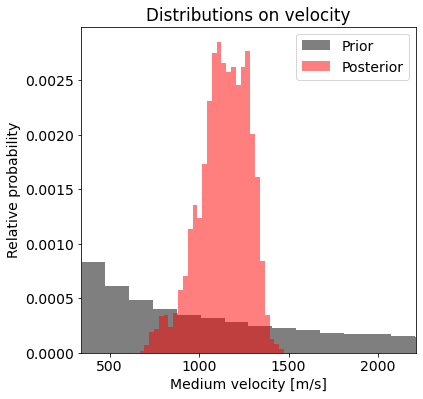

In [298]:
fig = plt.figure(figsize=figsize)
ax = plt.axes()


plt.title("Prior on medium P-wave velocity")
_ = ax.hist(
    (vel_prior.generate(50000).flatten()),
    color="k",
    alpha=0.5,
    bins=50,
    density=True,
    label="Prior",
)
plt.xlabel("Medium velocity [m/s]")
plt.ylabel("Relative probability")
# plt.show()

_, bins, _ = ax.hist(
    final_samples[-2, :], color="r", bins=30, density=True, alpha=0.5, label="Posterior"
)
ax.set_xlabel("Medium velocity [m/s]")
ax.set_ylabel("Relative probability")
plt.legend()
plt.title("Distributions on velocity")
_ = ax.set_xlim([340, bins.max() * 1.5])

Let's look at the best data fit over all samples from the $T=1$ chains. Additionally, the $0.1\sigma$ confidence intervals are plotted, to show that the best models are very close to the observed data.

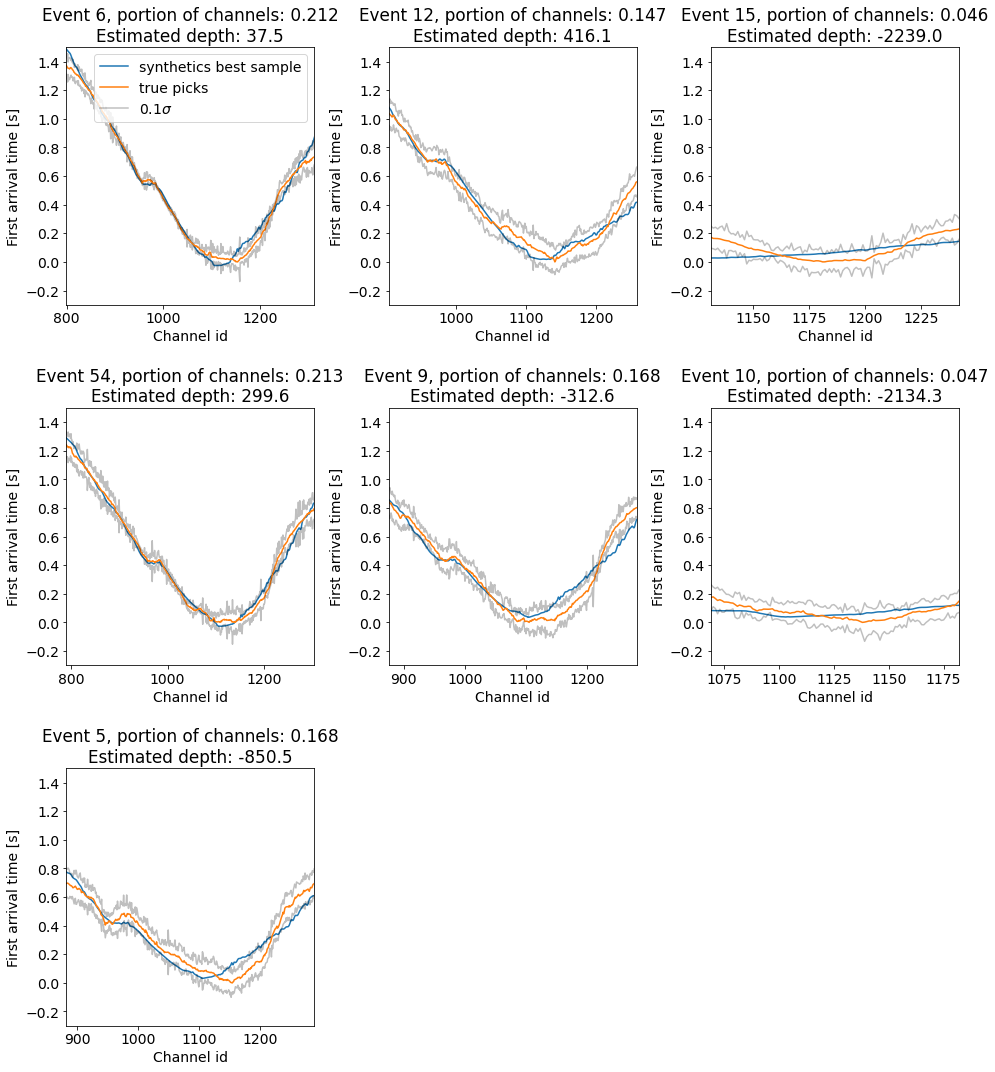

In [299]:
rows = math.ceil(n_events / 3)
plt.figure(figsize=(16, 6 * rows))
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4
)

for i in range(n_events):
    ax = plt.subplot(rows, 3, i + 1)
    plt.plot(synthetics_best_model_overall[i, :].T, label="synthetics best sample")
    dat = numpy.copy(data_array.T[i, :])

    dat_pls_sigma = numpy.copy((data_array + 0.1 * data_covariance**0.5).T[i, :])
    dat_min_sigma = numpy.copy((data_array - 0.1 * data_covariance**0.5).T[i, :])

    plt.plot(dat.T, label="true picks")
    plt.plot(dat_pls_sigma.T, "k", alpha=0.25)
    plt.plot(dat_min_sigma.T, "k", alpha=0.25, label="$0.1 \sigma$")
    plt.xlabel("Channel id")
    plt.ylabel("First arrival time [s]")

    plt.title(
        f"Event {event_descriptions[i]}, portion of channels: "
        f"{numpy.logical_not(numpy.isnan(dat.T)).sum()/numpy.logical_not(numpy.isnan(data_array)).sum():.3f}\n"
        f"Estimated depth: {final_samples[i * 4 + 2, :].mean():.1f}"
    )

    plt.xlim(
        [
            numpy.argmax(numpy.logical_not(numpy.isnan(dat.T))),
            len(dat.T) - 1 - numpy.argmax(numpy.logical_not(numpy.isnan(dat.T[::-1]))),
        ]
    )

    plt.ylim([-0.3, 1.5])

    if i == 0:
        plt.legend()

plt.show()

Lets now take a look at the most anticipated plots. The point clouds in 2D seen from the side are given below. In the cells later, we will also get a top down view.

In [301]:
m_final, x_final, ms, d = hmclab.Optimizers.gradient_descent(
    posteriors[0],
    initial_model=starting_models[0],
    epsilon=1e-4,
    iterations=int(1e3),
    strictly_monotonic=True,
)

KeyboardInterrupt: 

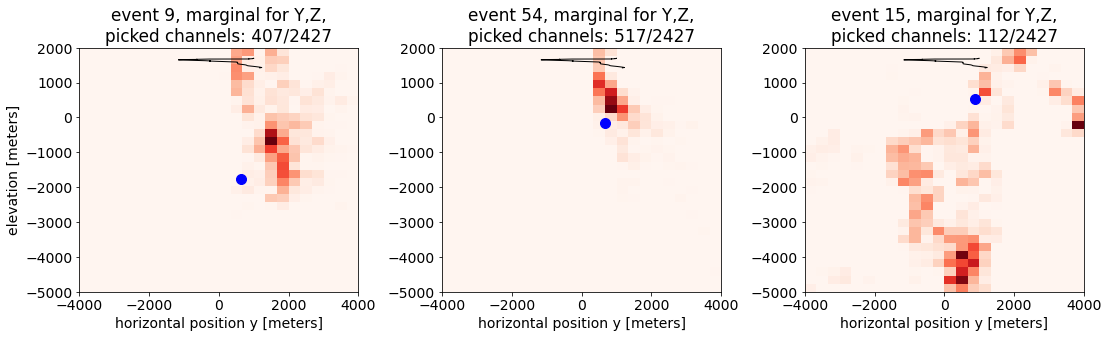

In [302]:
plt.figure(figsize=figsize_32)
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.tight_layout()
for i_subplot, event in enumerate([4, 3, 2]):

    # Grab y,z locations, and channel count ...
    y, z = final_samples[event * 4 + 1, :], final_samples[event * 4 + 2, :]

    y_det, z_det = m_final[1 + 4 * event], m_final[2 + 4 * event]
    channel_fraction = (
        numpy.logical_not(numpy.isnan(data_array[:, event])).sum()
        / numpy.logical_not(numpy.isnan(data_array)).sum()
    )

    # ... plot ...
    ax = plt.subplot(2, 3, i_subplot + 1 + 3)
    ax.plot(y_das, z_das_polar, c="k", linewidth=1)
    ax.hist2d(
        y[::1],
        z[::1],
        cmap=plt.get_cmap("Reds"),
        alpha=1,
        range=[[-5000, 5000], [-5000, 2000]],
        bins=30,
    )
    #     ax.scatter(y.mean(), z.mean(), c="b", s=100)
    ax.scatter(y_det, z_det, c="b", s=100)

    # ... and make pretty
    plt.title(
        f"event {event_descriptions[event]}, marginal for Y,Z,\npicked channels: "
        f"{numpy.logical_not(numpy.isnan(data_array[:, event])).sum()}"
        f"/{numpy.logical_not(numpy.isnan(data_array)).sum()}"
    )
    plt.xlim([-4000, 4000])
    plt.ylim([-5000, 2000])
    plt.xlabel("horizontal position y [meters]")
    if i_subplot == 0:
        plt.ylabel("elevation [meters]")
    plt.gca().set_aspect(1)

plt.show()

These plots really illustrate the varying uncertainty in locating these events. The direction of uncertainty strongly depends on where an event occured. Let's now view those same events top down:

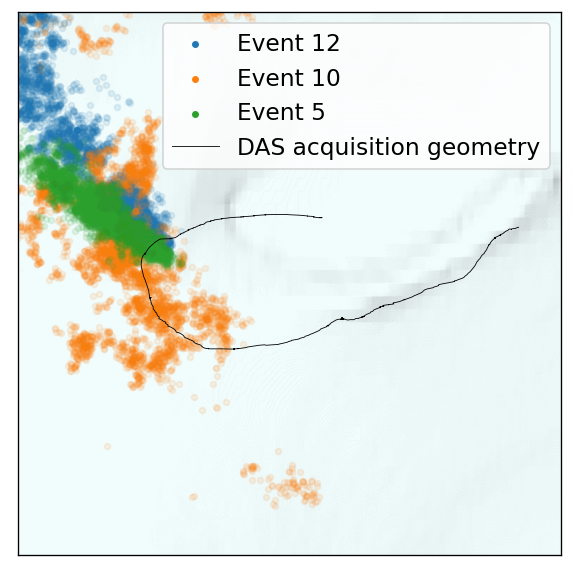

In [303]:
tilemapbase.init(create=True)

t = tilemapbase.tiles.Stamen_Terrain

degrees_range1 = 0.05
extent = tilemapbase_create_extent(
    (lon_das_polar.mean(), lat_das_polar.mean()), degrees_range1
)

fig, ax = plt.subplots(figsize=figsize, dpi=120)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)


plotter = tilemapbase.Plotter(extent, t, width=400)
plotter.plot(ax, t)

x_projected, y_projected = tilemapbase_project_array(
    lon_das_polar, lat_das_polar, tilemapbase.project
)


for i_event, event in enumerate([1, 5, 6]):

    # Samples to lon/lat
    samples_lon, samples_lat = to_lonlat(
        final_samples[event * 4 + 0, ::10] / 1e3,
        final_samples[event * 4 + 1, ::10] / 1e3,
        origin,
    )

    # Samples to unit square for map
    samples_lon, samples_lat = tilemapbase_project_array(
        samples_lon, samples_lat, tilemapbase.project
    )

    label = None
    label = f"Event {event_descriptions[event]}"

    # Plotting the samples, with a second trick to get a nice legend
    scatter = ax.scatter(
        samples_lon[::3], samples_lat[::3], s=50, marker=".", alpha=0.1
    )
    color = scatter.get_facecolors()[0].tolist()
    color[-1] = 1
    ax.scatter(samples_lon.mean(), samples_lat.mean(), s=10, color=color, label=label)


ax.plot(
    x_projected, y_projected, color="k", linewidth=0.5, label="DAS acquisition geometry"
)
plt.legend()

So these events are (as on might expect), the best localized in the direction that has the most channels, or, in the direction of the DAS cable. But these uncertainty volumes are not strictly Gaussian.

To summarize the statistics of all events, we can draw uncertainty-ellipses. These plots condense the posterior to a Gaussian approximation, allowing us to quickly distill the uncertainty information of many to a single plot. This is, however, not fully accurate if posteriors are highly non-linear. Nonetheless, the following plot should provide useful in localizing clusters of events and their typical orientations of uncertainty.

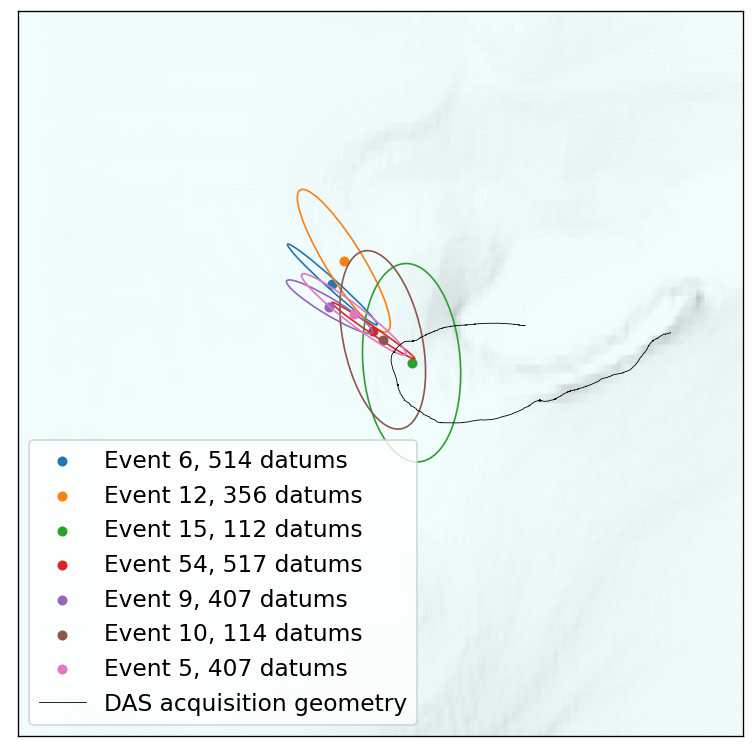

In [305]:
tilemapbase.init(create=True)

t = tilemapbase.tiles.Stamen_Terrain

degrees_range1 = 0.09
extent = tilemapbase_create_extent(
    (lon_das_polar.mean() - 0.06, lat_das_polar.mean()), degrees_range1
)

fig, ax = plt.subplots(figsize=(8, 8), dpi=120)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)


plotter = tilemapbase.Plotter(extent, t, width=400)
plotter.plot(ax, t)

x_projected, y_projected = tilemapbase_project_array(
    lon_das_polar, lat_das_polar, tilemapbase.project
)


for i in range(n_events):

    samples_lon, samples_lat = to_lonlat(
        final_samples[i * 4 + 0] / 1e3, final_samples[i * 4 + 1] / 1e3, origin
    )

    samples_lon_projected, samples_lat_projected = tilemapbase_project_array(
        samples_lon, samples_lat, tilemapbase.project
    )

    label = (
        f"Event {event_descriptions[i]}, "
        + f"{numpy.sum(numpy.logical_not(numpy.isnan(data_array[:,i])))} datums"
    )
    #     if i == 0:
    #         label = "potential location and uncertainty"
    ln = ax.scatter(
        samples_lon_projected.mean(),
        samples_lat_projected.mean(),
        s=100,
        marker=".",
        #         c="r",
        label=label,
    )

    confidence_ellipse(
        samples_lon_projected,
        samples_lat_projected,
        ax,
        n_std=1,
        edgecolor=ln.get_edgecolor(),  # "red"
    )

ax.plot(
    x_projected, y_projected, color="k", linewidth=0.5, label="DAS acquisition geometry"
)
plt.legend()

Exception ignored in: <function tqdm.__del__ at 0x12139d670>
Traceback (most recent call last):
  File "/opt/miniforge3/envs/hmclab-dev/lib/python3.8/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/opt/miniforge3/envs/hmclab-dev/lib/python3.8/site-packages/tqdm/notebook.py", line 281, in close
    if self.disable:
AttributeError: 'tqdm' object has no attribute 'disable'


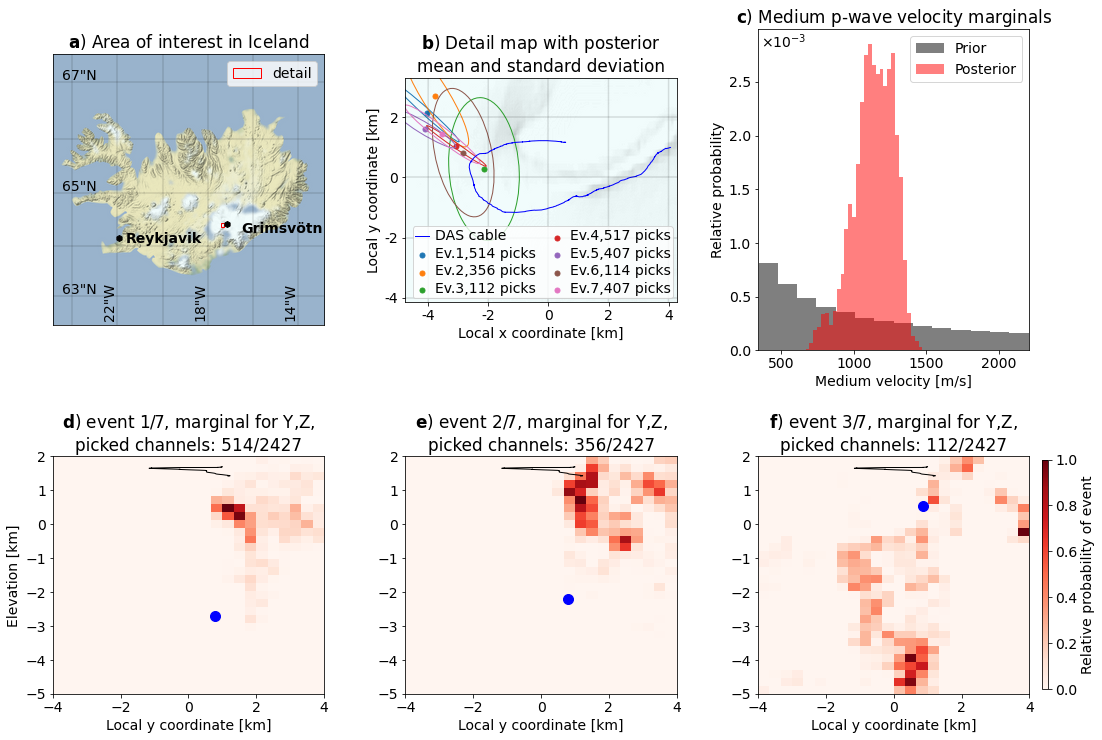

In [306]:
##### import matplotlib

font = {  #'family' : 'normal',
    #         'weight' : 'bold',
    "size": 14
}

matplotlib.rc("font", **font)
plt.figure(figsize=(17.5, 13))
plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.tight_layout()
for i_subplot, event in enumerate([0, 1, 2]):

    # Grab y,z locations, and channel count ...
    y, z = final_samples[event * 4 + 1, :], final_samples[event * 4 + 2, :]

    y_det, z_det = m_final[1 + 4 * event], m_final[2 + 4 * event]
    channel_fraction = (
        numpy.logical_not(numpy.isnan(data_array[:, event])).sum()
        / numpy.logical_not(numpy.isnan(data_array)).sum()
    )

    # ... plot ...
    ax = plt.subplot(2, 3, i_subplot + 1 + 3)
    ax.plot(y_das / 1000, z_das_polar / 1000, c="k", linewidth=1)
    imh = ax.hist2d(
        y[::1] / 1000,
        z[::1] / 1000,
        cmap=plt.get_cmap("Reds"),
        alpha=1,
        density=True,
        range=[[-5, 5], [-5, 2]],
        bins=30,
    )
    #     ax.scatter(y.mean(), z.mean(), c="b", s=100)
    ax.scatter(y_det / 1000, z_det / 1000, c="b", s=100)

    # ... and make pretty
    plt.title(
        f"event {i_subplot+1}/7, marginal for Y,Z,\npicked channels: "
        f"{numpy.logical_not(numpy.isnan(data_array[:, event])).sum()}"
        f"/{numpy.logical_not(numpy.isnan(data_array)).sum()}"
    )
    plt.xlim([-4, 4])
    plt.ylim([-5, 2])
    plt.xlabel("Local y coordinate [km]")
    if i_subplot == 0:
        plt.ylabel("Elevation [km]")
    plt.gca().set_aspect(1)

plt.subplot(2, 3, 3)
ax = plt.gca()

plt.title("Prior on medium P-wave velocity")
_ = ax.hist(
    (vel_prior.generate(50000).flatten()),
    color="k",
    alpha=0.5,
    bins=50,
    density=True,
    label="Prior",
)
plt.xlabel("Medium velocity [m/s]")
plt.ylabel("Relative probability")
# plt.show()

_, bins, _ = ax.hist(
    final_samples[-2, :], color="r", bins=30, density=True, alpha=0.5, label="Posterior"
)
ax.set_xlabel("Medium velocity [m/s]")
ax.set_ylabel("Relative probability")
plt.legend()
plt.title("Medium p-wave velocity marginals")
_ = ax.set_xlim([340, bins.max() * 1.5])

# Set the background image source
tilemapbase.init(create=True)
map_background = tilemapbase.tiles.Stamen_Terrain_Background

# Set the map extent of the maps
degrees_range1 = 3
extent1 = tilemapbase_create_extent(
    (lon_das_polar.mean() - 1.5, lat_das_polar.mean() + 0.5), degrees_range1
)
degrees_range2 = 0.07
extent2 = tilemapbase_create_extent(
    (lon_das_polar.mean(), lat_das_polar.mean()), degrees_range2
)

degrees_range2 = 0.035
extent2_alt = tilemapbase_create_extent(
    (lon_das_polar.mean(), lat_das_polar.mean()), degrees_range2
)


# Create figure and axes
# fig = plt.figure(figsize=figsize_double, dpi=120)
ax1 = plt.subplot(231)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax2 = plt.subplot(232)
# ax2.xaxis.set_visible(False)
# ax2.yaxis.set_visible(False)

# Create the backgrounds in the axes
plotter1 = tilemapbase.Plotter(extent1, map_background, width=400)
plotter1.plot(ax1, map_background)
plotter2 = tilemapbase.Plotter(extent2, map_background, width=400)
plotter2.plot(ax2, map_background)

# Plot the inset
rectangle = patches.Rectangle(
    (extent2_alt.xmin, extent2_alt.ymin),
    extent2_alt.width,
    extent2_alt.height,
    linewidth=1,
    edgecolor="r",
    facecolor="none",
    label="detail",
)
ax1.add_patch(rectangle)

# Project the DAS geometry to map coordinates
xproj_das, yproj_das = tilemapbase_project_array(
    lon_das_polar, lat_das_polar, tilemapbase.project
)

# Plot the cable
ax2.plot(xproj_das, yproj_das, color="b", linewidth=1, label="DAS cable")

# Plot a grid (messy!)

## AX 2
## LONS

lo, ro = lon_das_polar.mean() - 8, lon_das_polar.mean() + 10

for cor in numpy.arange(63, 68, 1.0):
    xproj_grid, yproj_grid = tilemapbase_project_array(
        [ro, lo],
        [cor, cor],
        tilemapbase.project,
    )
    ax1.plot(xproj_grid, yproj_grid, color="k", alpha=0.125)

    if (cor - 1) % 2 == 0:
        ax1.text(xproj_grid[1] + 0.0025, yproj_grid[0] - 3e-4, f'{int(cor)}"N')


## LATS
la, ra = lat_das_polar.mean() - 2.5, lat_das_polar.mean() + 3.5
for cor in numpy.arange(-24, -10, 2.0):
    xproj_grid, yproj_grid = tilemapbase_project_array(
        [cor, cor],
        [ra, la],
        tilemapbase.project,
    )
    ax1.plot(xproj_grid, yproj_grid, color="k", alpha=0.125)

    if (cor - 2) % 4 == 0:
        ax1.text(
            xproj_grid[0] - 1.8e-3,
            yproj_grid[1] - 0.004,
            f'{int(abs(cor))}"W',
            ha="left",
            rotation=90,
        )


## AX 2

## LONS
# lo, ro = lon_das_polar.mean() - 0.75, lon_das_polar.mean() + 0.75

# for cor in numpy.arange(64.2, 64.8, 0.2):
#     xproj_grid, yproj_grid = tilemapbase_project_array(
#         [ro, lo],
#         [cor, cor],
#         tilemapbase.project,
#     )
#     ax2.plot(xproj_grid, yproj_grid, color="k", linewidth=0.2, alpha=1)
#     if True:  # (cor - 1) % 2 == 0:
#         ax2.text(
#             xproj_grid[1] + 0.00025, yproj_grid[0] - 3e-5, f'{numpy.round(cor,1)}"N'
#         )


# ## LATS
# la, ra = lat_das_polar.mean() - 0.3, lat_das_polar.mean() + 0.3
# for cor in numpy.arange(-18, -16, 0.4):
#     xproj_grid, yproj_grid = tilemapbase_project_array(
#         [cor, cor],
#         [ra, la],
#         tilemapbase.project,
#     )
#     ax2.plot(xproj_grid, yproj_grid, color="k", linewidth=0.2, alpha=1)

#     if numpy.round(cor * 10) % 8 == 0:
#         ax2.text(
#             xproj_grid[0] - 1.3e-4,
#             yproj_grid[1] - 0.000075,
#             f'{(numpy.round(abs(cor),1))}"W',
#             ha="left",
#             rotation=90,
#         )


# Plot a city
reykjavik = [-21.9426], [64.1466]
xproj_reykjavik, yproj_reykjavik = tilemapbase_project_array(
    reykjavik[0],
    reykjavik[1],
    tilemapbase.project,
)
ax1.scatter(xproj_reykjavik, yproj_reykjavik, marker="h", c="k")  # , label="Reykjavik")
ax1.annotate(
    "Reykjavik",
    xy=tuple(1.002 * numpy.array([xproj_reykjavik, yproj_reykjavik]).flatten()),
    fontweight=600,
)


grimsvotn = [-17.163333], [64.42]
xproj_reykjavik, yproj_reykjavik = tilemapbase_project_array(
    grimsvotn[0],
    grimsvotn[1],
    tilemapbase.project,
)
ax1.scatter(xproj_reykjavik, yproj_reykjavik, marker="h", c="k")  # , label="Reykjavik")
ax1.annotate(
    "Grimsvötn",
    xy=tuple(1.004 * numpy.array([xproj_reykjavik, yproj_reykjavik]).flatten()),
    fontweight=600,
)


ax1.set_title("Area of interest in Iceland")
ax2.set_title("Detail map with posterior\nmean and standard deviation")


# Add legends
_ = ax1.legend()
_ = ax2.legend()


x_projected, y_projected = tilemapbase_project_array(
    lon_das_polar, lat_das_polar, tilemapbase.project
)
ax = plt.subplot(232)


# _events = [4, 3, 2, 1, 0, 5, 6]
for i in range(n_events):

    samples_lon, samples_lat = to_lonlat(
        final_samples[i * 4 + 0] / 1e3, final_samples[i * 4 + 1] / 1e3, origin
    )

    samples_lon_projected, samples_lat_projected = tilemapbase_project_array(
        samples_lon, samples_lat, tilemapbase.project
    )

    label = (
        f"Ev.{i+1},"
        + f"{numpy.sum(numpy.logical_not(numpy.isnan(data_array[:,i])))} picks"
    )
    #     if i == 0:
    #         label = "potential location and uncertainty"
    ln = ax.scatter(
        samples_lon_projected.mean(),
        samples_lat_projected.mean(),
        s=100,
        marker=".",
        #         c="r",
        label=label,
    )

    confidence_ellipse(
        samples_lon_projected,
        samples_lat_projected,
        ax,
        n_std=1,
        edgecolor=ln.get_edgecolor(),  # "red"
    )

ax.set_xlim((0.4515, 0.4521))
ax.set_ylim((0.2644, 0.2638))


kwargs = {
    "borderpad": 0.5 * 0.4,
    "labelspacing": 0.5 * 0.5,
    "handlelength": 0.5 * 2.0,
    "handleheight": 0.5 * 0.7,
    "handletextpad": 0.5 * 0.8,
    "borderaxespad": 0.5 * 0.5,
    "columnspacing": 0.5 * 2,
}

plt.legend(loc="lower right", ncol=2, **kwargs)


tens = numpy.arange(-10, 10, 2)
lower_x, lower_y = to_lonlat(tens, numpy.ones_like(tens) * -10, origin)
lower_x, lower_y = tilemapbase_project_array(lower_x, lower_y, tilemapbase.project)
plt.scatter(lower_x, lower_y)

tens = numpy.arange(-10, 10, 2)
upper_x, upper_y = to_lonlat(tens, numpy.ones_like(tens) * 10, origin)
upper_x, upper_y = tilemapbase_project_array(upper_x, upper_y, tilemapbase.project)

x = numpy.vstack((upper_x, lower_x)).reshape((-1,), order="F")
y = numpy.vstack((upper_y, lower_y)).reshape((-1,), order="F")

# plt.figure()
locs, labels = [], []

for i in range(100):
    plt.plot(x[i * 2 : i * 2 + 2], y[i * 2 : i * 2 + 2], color="k", alpha=0.125)

    try:
        locs.append(x[i * 2]), labels.append(tens[i])
    except IndexError:
        pass


plt.xticks(locs, labels)  # Set locations and labels


tens = numpy.arange(-10, 10, 2)
lower_x, lower_y = to_lonlat(numpy.ones_like(tens) * -10, tens, origin)
lower_x, lower_y = tilemapbase_project_array(lower_x, lower_y, tilemapbase.project)
plt.scatter(lower_x, lower_y)

tens = numpy.arange(-10, 10, 2)
upper_x, upper_y = to_lonlat(numpy.ones_like(tens) * 10, tens, origin)
upper_x, upper_y = tilemapbase_project_array(upper_x, upper_y, tilemapbase.project)

x = numpy.vstack((upper_x, lower_x)).reshape((-1,), order="F")
y = numpy.vstack((upper_y, lower_y)).reshape((-1,), order="F")

locs, labels = [], []
for i in range(100):
    plt.plot(x[i * 2 : i * 2 + 2], y[i * 2 : i * 2 + 2], color="k", alpha=0.125)

    try:
        locs.append(y[i * 2]), labels.append(tens[i])
    except IndexError:
        pass


plt.yticks(locs, labels)  # Set locations and labels

ax.set_xlim((0.45152, 0.45204))
ax.set_ylim((0.26440, 0.26397))
ax.set_xlabel("Local x coordinate [km]")
ax.set_ylabel("Local y coordinate [km]")

plt.subplot(233)
plt.gca().ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
import numpy as np

ax1 = plt.gca()
ax1.get_yaxis().get_offset_text().set_visible(False)
ax_max = max(ax1.get_yticks())
exponent_axis = np.floor(np.log10(ax_max)).astype(int)
ax1.annotate(
    r"$\times$10$^{%i}$" % (exponent_axis), xy=(0.01, 0.94), xycoords="axes fraction"
)


# plt.gcf().text(0.12, 0.86, "a)", fontsize=18,weight="bold")

for i in range(6):
    plt.subplot(2, 3, i + 1)
    abc = "abcdefgh"
    plt.gca().set_title("$\\bf{"+ abc[i]+"}$) " + plt.gca().get_title())

plt.subplot(2,3,6)
ax = plt.gca()
# ax1_divider = make_axes_locatable(ax)
# cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")

axes = plt.gcf().add_axes([0.91, 0.175, 0.005, 0.245])

cb1 = plt.gcf().colorbar(None, cax=axes, cmap=plt.get_cmap("Reds"))
cb1.ax.set_ylabel("Relative probability of event")

    
plt.savefig("tri.pdf")


plt.show()

In [307]:
!open tri.pdf

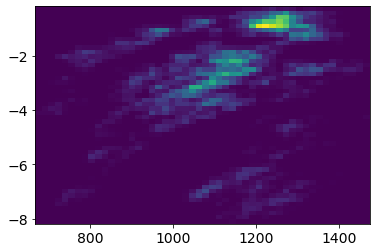

In [308]:
_ = plt.hist2d(final_samples[-2,:],final_samples[3+4*6,:],bins=50)